In [1]:
import glob
import numpy as np
import pandas as pd
import torch 
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms as T, datasets, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm.autonotebook import tqdm


In [2]:
path2data = "../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/"
class_names = os.listdir(path2data)
print(class_names)
print(f"{class_names[0]}:",len(os.listdir(os.path.join(path2data,class_names[0]))))
print(f"{class_names[1]}:",len(os.listdir(os.path.join(path2data,class_names[1]))))
print(f"{class_names[2]}:",len(os.listdir(os.path.join(path2data,class_names[2]))))

['benign', 'normal', 'malignant']
benign: 891
normal: 266
malignant: 421


In [3]:
benign_all_files = [i for i in glob.glob("../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/*.png") if i.find("mask") == -1 ]
malignant_all_files = [i for i in glob.glob("../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant/*.png") if i.find("mask") == -1 ]
normal_all_files = [i for i in glob.glob("../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/*.png") if i.find("mask") == -1 ]

test_file_paths = []
test_file_paths.extend(benign_all_files[:30])
test_file_paths.extend(malignant_all_files[:30])
test_file_paths.extend(normal_all_files[:30])

train_file_paths = np.concatenate((benign_all_files,malignant_all_files,normal_all_files))
train_files_paths = np.setdiff1d(train_file_paths, test_file_paths)

os.makedirs("./train", exist_ok=True)
os.makedirs("./test", exist_ok=True)
for i in class_names:
    os.makedirs(f"./train/{i}", exist_ok=True)
    os.makedirs(f"./test/{i}", exist_ok=True)

from PIL import Image
for i in tqdm(train_file_paths):
    a = Image.open(i)
    a = a.resize((224,224))
    a = np.array(a)
    np.save(f"./train/{i.split('/')[-2]}/{i.split('/')[-1][:-4]}.npy", a)


for i in tqdm(test_file_paths):
    a = Image.open(i)
    a = a.resize((224,224))
    a = np.array(a)
    np.save(f"./test/{i.split('/')[-2]}/{i.split('/')[-1][:-4]}.npy", a)

  0%|          | 0/780 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

In [4]:
train_loc = "./train/"
test_loc = "./test/"
def load_file(path):
    return np.load(path).astype(np.float32)

### Calculating Mean

In [5]:
trainset = datasets.DatasetFolder(train_loc, transform = T.Compose([T.ToTensor()]), loader=load_file, extensions="npy")
trainloader = DataLoader(trainset,batch_size = 64,shuffle = True)
def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


mean, std = get_mean_std(trainloader)
print(mean)
print(std)

  0%|          | 0/13 [00:00<?, ?it/s]

tensor([83.8764, 83.8747, 83.8639])
tensor([56.4685, 56.4684, 56.4648])


In [6]:
TRAIN = 'train'
TEST = 'test'
def data_transform(phase = None):
    if phase == TRAIN:
        data_T = T.Compose([
            T.ToTensor(),
            T.Normalize([83.6046, 83.6027, 83.5871],[56.0671, 56.0670, 56.0605])
        ])
        
    elif phase == TEST:
        data_T = T.Compose([
            T.ToTensor(), 
            T.Normalize([83.6046, 83.6027, 83.5871],[56.0671, 56.0670, 56.0605])
        ])
    return data_T

In [7]:
trainset = datasets.DatasetFolder(train_loc, transform = data_transform(TRAIN), loader=load_file, extensions="npy")
testset = datasets.DatasetFolder(test_loc, transform = data_transform(TEST), loader=load_file, extensions="npy")

In [8]:
class_name = trainset.classes
print(class_name)
print(trainset.class_to_idx)

['benign', 'malignant', 'normal']
{'benign': 0, 'malignant': 1, 'normal': 2}


  0%|          | 0/780 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Train_set')

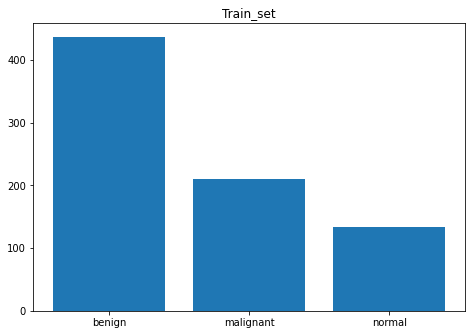

In [9]:
def get_class_count(dataset):
    class_name = dataset.classes
    classes = []
    for _,labels in tqdm(dataset):
        classes.append(class_name[labels])
    return classes

count = get_class_count(trainset)
unique, counts = np.unique(count, return_counts=True)
dict(zip(unique, counts))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(unique,counts)
ax.set_title("Train_set")


  0%|          | 0/90 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Test_set')

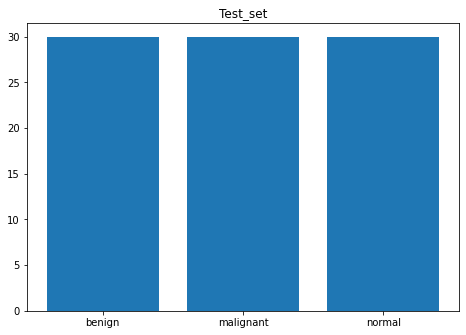

In [10]:
count = get_class_count(testset)
unique, counts = np.unique(count, return_counts=True)
dict(zip(unique, counts))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(unique,counts)
ax.set_title("Test_set")


In [11]:
trainloader = DataLoader(trainset,batch_size = 16,shuffle = True)
testloader = DataLoader(testset,batch_size = 32,shuffle = False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 3),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

for param in model.parameters():
    param.require_grad = True
model.to(device);

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
def accuracy(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [14]:
def training(trainloader, testloader, epochs, model_name):
    train_loss_hist = []
    test_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []
    test_loss_min = np.Inf
    
    for i in range(epochs):

        train_loss = 0.0
        test_loss = 0.0
        train_acc = 0.0
        test_acc = 0.0 


        model.train()

        for images,labels in tqdm(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            ps = model(images)
            loss = criterion(ps,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_acc += accuracy(ps,labels)
            train_loss += loss.item()

        avg_train_acc = train_acc / len(trainloader)
        train_acc_hist.append(avg_train_acc)
        avg_train_loss = train_loss / len(trainloader)
        train_loss_hist.append(avg_train_loss)

        model.eval()
        with torch.no_grad():

            for images,labels in tqdm(testloader):

                images = images.to(device)
                labels = labels.to(device)

                ps = model(images)
                loss = criterion(ps,labels)

                test_acc += accuracy(ps,labels)
                test_loss += loss.item()


            avg_test_acc = test_acc / len(testloader)
            test_acc_hist.append(avg_test_acc)
            avg_test_loss = test_loss / len(testloader)
            test_loss_hist.append(avg_test_loss)

            schedular.step(avg_test_loss)

            if avg_test_loss <= test_loss_min:
                print('Test loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(test_loss_min,avg_test_loss))
                torch.save({
                    'epoch' : i,
                    'model_state_dict' : model.state_dict(),
                    'optimizer_state_dict' : optimizer.state_dict(),
                    'test_loss_min' : avg_test_loss
                },f'{model_name}.pt')

                test_loss_min = avg_test_loss

        print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
        print("Epoch : {} test Loss : {:.6f} test Acc : {:.6f}".format(i+1,avg_test_loss,avg_test_acc))
    
    plt.figure()
    plt.plot(train_loss_hist)
    plt.plot(test_loss_hist)
    plt.show()
    plt.figure()
    plt.plot(train_acc_hist)
    plt.plot(test_acc_hist)
    plt.show()

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Pretrained = False

original train dataset length: 780
new train dataset length: 78


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 18.622220).   Saving model ...
Epoch : 1 Train Loss : 1.597025 Train Acc : 0.357143
Epoch : 1 test Loss : 18.622220 test Acc : 0.312500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (18.622220 --> 6.768277).   Saving model ...
Epoch : 2 Train Loss : 1.225823 Train Acc : 0.542857
Epoch : 2 test Loss : 6.768277 test Acc : 0.312500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.900473 Train Acc : 0.553571
Epoch : 3 test Loss : 20.411982 test Acc : 0.325321


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.773517 Train Acc : 0.637500
Epoch : 4 test Loss : 8.390019 test Acc : 0.325321


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.688009 Train Acc : 0.644643
Epoch : 5 test Loss : 11.146811 test Acc : 0.327724


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (6.768277 --> 4.051744).   Saving model ...
Epoch : 6 Train Loss : 0.510736 Train Acc : 0.766071
Epoch : 6 test Loss : 4.051744 test Acc : 0.382212


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.464816 Train Acc : 0.832143
Epoch : 7 test Loss : 7.347387 test Acc : 0.348558


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.528856 Train Acc : 0.810714
Epoch : 8 test Loss : 5.424692 test Acc : 0.379808


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.358125 Train Acc : 0.855357
Epoch : 9 test Loss : 6.744932 test Acc : 0.366987


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (4.051744 --> 1.611898).   Saving model ...
Epoch : 10 Train Loss : 0.342614 Train Acc : 0.858929
Epoch : 10 test Loss : 1.611898 test Acc : 0.548077


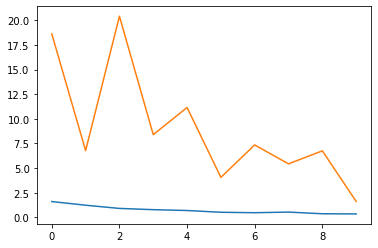

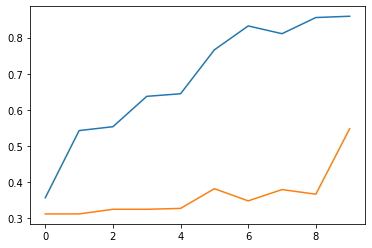

original train dataset length: 780
new train dataset length: 156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 49.554578).   Saving model ...
Epoch : 1 Train Loss : 1.290365 Train Acc : 0.537500
Epoch : 1 test Loss : 49.554578 test Acc : 0.312500


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (49.554578 --> 2.924752).   Saving model ...
Epoch : 2 Train Loss : 0.849038 Train Acc : 0.668750
Epoch : 2 test Loss : 2.924752 test Acc : 0.413462


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.783280 Train Acc : 0.695833
Epoch : 3 test Loss : 3.175073 test Acc : 0.443109


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.725350 Train Acc : 0.679167
Epoch : 4 test Loss : 6.229408 test Acc : 0.312500


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (2.924752 --> 1.440993).   Saving model ...
Epoch : 5 Train Loss : 0.624363 Train Acc : 0.741667
Epoch : 5 test Loss : 1.440993 test Acc : 0.395032


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.440993 --> 0.972431).   Saving model ...
Epoch : 6 Train Loss : 0.538602 Train Acc : 0.762500
Epoch : 6 test Loss : 0.972431 test Acc : 0.653045


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.510704 Train Acc : 0.795833
Epoch : 7 test Loss : 4.529791 test Acc : 0.390224


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.471155 Train Acc : 0.787500
Epoch : 8 test Loss : 1.052069 test Acc : 0.560897


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.339727 Train Acc : 0.879167
Epoch : 9 test Loss : 1.683660 test Acc : 0.436699


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.289413 Train Acc : 0.889583
Epoch : 10 test Loss : 1.606808 test Acc : 0.490385


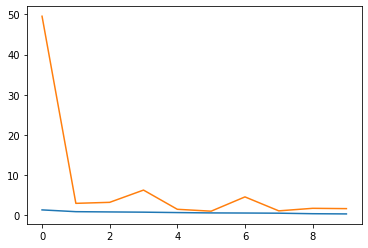

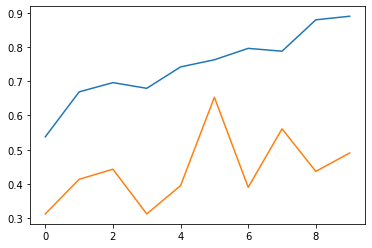

original train dataset length: 780
new train dataset length: 234


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 2.854634).   Saving model ...
Epoch : 1 Train Loss : 1.203161 Train Acc : 0.534167
Epoch : 1 test Loss : 2.854634 test Acc : 0.312500


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.829178 Train Acc : 0.634167
Epoch : 2 test Loss : 4.074099 test Acc : 0.312500


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (2.854634 --> 1.637460).   Saving model ...
Epoch : 3 Train Loss : 0.759272 Train Acc : 0.669167
Epoch : 3 test Loss : 1.637460 test Acc : 0.479167


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.637460 --> 1.155155).   Saving model ...
Epoch : 4 Train Loss : 0.724835 Train Acc : 0.690000
Epoch : 4 test Loss : 1.155155 test Acc : 0.507212


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.583529 Train Acc : 0.784167
Epoch : 5 test Loss : 1.615045 test Acc : 0.439904


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.620125 Train Acc : 0.740000
Epoch : 6 test Loss : 2.790845 test Acc : 0.348558


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.624418 Train Acc : 0.744167
Epoch : 7 test Loss : 1.228492 test Acc : 0.520032


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.155155 --> 0.832077).   Saving model ...
Epoch : 8 Train Loss : 0.507425 Train Acc : 0.832500
Epoch : 8 test Loss : 0.832077 test Acc : 0.702724


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.832077 --> 0.734499).   Saving model ...
Epoch : 9 Train Loss : 0.410570 Train Acc : 0.853333
Epoch : 9 test Loss : 0.734499 test Acc : 0.681090


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.466653 Train Acc : 0.826667
Epoch : 10 test Loss : 1.947950 test Acc : 0.498397


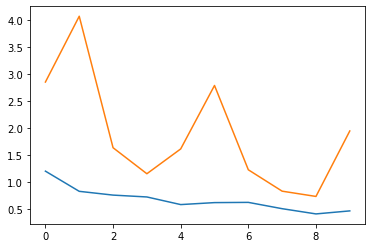

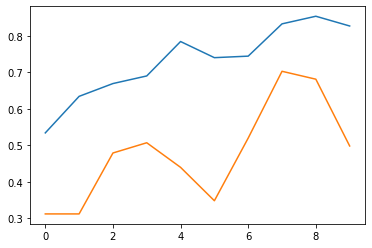

original train dataset length: 780
new train dataset length: 312


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 14.139116).   Saving model ...
Epoch : 1 Train Loss : 1.165594 Train Acc : 0.528125
Epoch : 1 test Loss : 14.139116 test Acc : 0.343750


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (14.139116 --> 1.092079).   Saving model ...
Epoch : 2 Train Loss : 0.827180 Train Acc : 0.653125
Epoch : 2 test Loss : 1.092079 test Acc : 0.506410


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.092079 --> 0.758480).   Saving model ...
Epoch : 3 Train Loss : 0.693647 Train Acc : 0.696875
Epoch : 3 test Loss : 0.758480 test Acc : 0.642628


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.674277 Train Acc : 0.743750
Epoch : 4 test Loss : 1.907442 test Acc : 0.493590


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.758480 --> 0.579264).   Saving model ...
Epoch : 5 Train Loss : 0.609649 Train Acc : 0.778125
Epoch : 5 test Loss : 0.579264 test Acc : 0.772436


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.536250 Train Acc : 0.806250
Epoch : 6 test Loss : 0.891362 test Acc : 0.724359


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.378713 Train Acc : 0.828125
Epoch : 7 test Loss : 3.328867 test Acc : 0.522436


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.445118 Train Acc : 0.818750
Epoch : 8 test Loss : 0.916655 test Acc : 0.737981


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.296821 Train Acc : 0.893750
Epoch : 9 test Loss : 1.548127 test Acc : 0.607372


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.366973 Train Acc : 0.884375
Epoch : 10 test Loss : 0.826249 test Acc : 0.784455


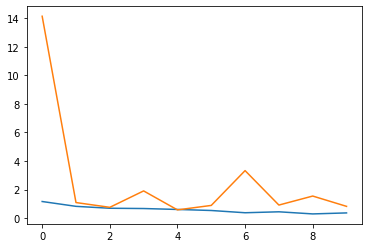

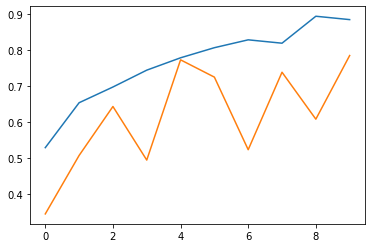

original train dataset length: 780
new train dataset length: 390


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 2.626078).   Saving model ...
Epoch : 1 Train Loss : 1.095653 Train Acc : 0.550833
Epoch : 1 test Loss : 2.626078 test Acc : 0.395833


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (2.626078 --> 1.413413).   Saving model ...
Epoch : 2 Train Loss : 0.811535 Train Acc : 0.655833
Epoch : 2 test Loss : 1.413413 test Acc : 0.457532


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.764860 Train Acc : 0.676667
Epoch : 3 test Loss : 1.736985 test Acc : 0.438301


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.632191 Train Acc : 0.734167
Epoch : 4 test Loss : 5.473605 test Acc : 0.343750


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.639000 Train Acc : 0.728333
Epoch : 5 test Loss : 2.388823 test Acc : 0.552083


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.413413 --> 1.042025).   Saving model ...
Epoch : 6 Train Loss : 0.626797 Train Acc : 0.721667
Epoch : 6 test Loss : 1.042025 test Acc : 0.580128


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.042025 --> 0.792240).   Saving model ...
Epoch : 7 Train Loss : 0.523122 Train Acc : 0.815000
Epoch : 7 test Loss : 0.792240 test Acc : 0.637821


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.446747 Train Acc : 0.825000
Epoch : 8 test Loss : 0.998223 test Acc : 0.627404


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.358356 Train Acc : 0.859167
Epoch : 9 test Loss : 1.488978 test Acc : 0.660256


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.333367 Train Acc : 0.858333
Epoch : 10 test Loss : 0.874616 test Acc : 0.717147


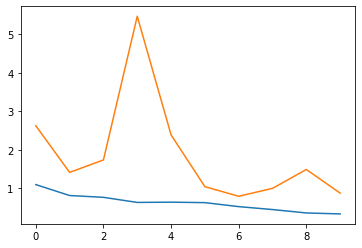

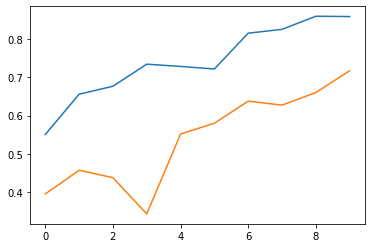

original train dataset length: 780
new train dataset length: 468


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 2.798302).   Saving model ...
Epoch : 1 Train Loss : 1.138034 Train Acc : 0.543750
Epoch : 1 test Loss : 2.798302 test Acc : 0.354167


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (2.798302 --> 2.387376).   Saving model ...
Epoch : 2 Train Loss : 0.826700 Train Acc : 0.691667
Epoch : 2 test Loss : 2.387376 test Acc : 0.322917


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (2.387376 --> 1.337427).   Saving model ...
Epoch : 3 Train Loss : 0.750294 Train Acc : 0.689583
Epoch : 3 test Loss : 1.337427 test Acc : 0.395833


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.337427 --> 0.718484).   Saving model ...
Epoch : 4 Train Loss : 0.725525 Train Acc : 0.700000
Epoch : 4 test Loss : 0.718484 test Acc : 0.742788


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.703175 Train Acc : 0.716667
Epoch : 5 test Loss : 1.290857 test Acc : 0.398237


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.718484 --> 0.710176).   Saving model ...
Epoch : 6 Train Loss : 0.686693 Train Acc : 0.731250
Epoch : 6 test Loss : 0.710176 test Acc : 0.679487


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.572240 Train Acc : 0.775000
Epoch : 7 test Loss : 2.443186 test Acc : 0.468750


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.710176 --> 0.704707).   Saving model ...
Epoch : 8 Train Loss : 0.668152 Train Acc : 0.727083
Epoch : 8 test Loss : 0.704707 test Acc : 0.669872


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.460954 Train Acc : 0.833333
Epoch : 9 test Loss : 2.398094 test Acc : 0.496795


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.588506 Train Acc : 0.760417
Epoch : 10 test Loss : 1.068959 test Acc : 0.552885


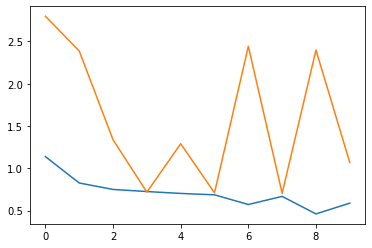

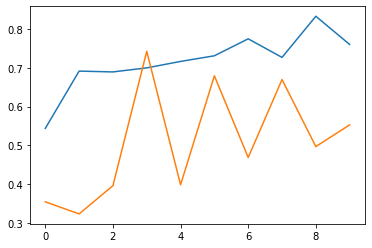

original train dataset length: 780
new train dataset length: 546


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 1.513297).   Saving model ...
Epoch : 1 Train Loss : 1.051069 Train Acc : 0.550000
Epoch : 1 test Loss : 1.513297 test Acc : 0.350962


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.798944 Train Acc : 0.666071
Epoch : 2 test Loss : 1.552214 test Acc : 0.482372


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.513297 --> 0.729175).   Saving model ...
Epoch : 3 Train Loss : 0.706060 Train Acc : 0.705357
Epoch : 3 test Loss : 0.729175 test Acc : 0.749199


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.631512 Train Acc : 0.732143
Epoch : 4 test Loss : 3.025481 test Acc : 0.468750


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.729175 --> 0.543471).   Saving model ...
Epoch : 5 Train Loss : 0.589673 Train Acc : 0.748214
Epoch : 5 test Loss : 0.543471 test Acc : 0.770833


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.543471 --> 0.390491).   Saving model ...
Epoch : 6 Train Loss : 0.476312 Train Acc : 0.807143
Epoch : 6 test Loss : 0.390491 test Acc : 0.880609


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.492473 Train Acc : 0.803571
Epoch : 7 test Loss : 0.853588 test Acc : 0.744391


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.533911 Train Acc : 0.787500
Epoch : 8 test Loss : 0.470477 test Acc : 0.839744


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.368147 Train Acc : 0.842857
Epoch : 9 test Loss : 0.404952 test Acc : 0.836538


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.450510 Train Acc : 0.821429
Epoch : 10 test Loss : 2.410927 test Acc : 0.545673


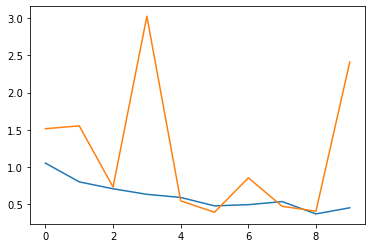

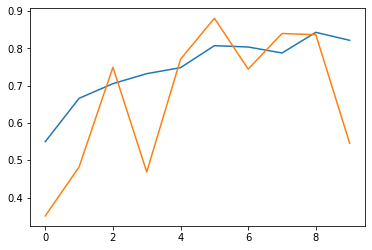

original train dataset length: 780
new train dataset length: 624


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 2.408020).   Saving model ...
Epoch : 1 Train Loss : 1.022535 Train Acc : 0.572115
Epoch : 1 test Loss : 2.408020 test Acc : 0.354167


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.840665 Train Acc : 0.650641
Epoch : 2 test Loss : 3.420240 test Acc : 0.333333


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (2.408020 --> 1.084552).   Saving model ...
Epoch : 3 Train Loss : 0.800851 Train Acc : 0.666667
Epoch : 3 test Loss : 1.084552 test Acc : 0.555288


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.723681 Train Acc : 0.705128
Epoch : 4 test Loss : 2.302981 test Acc : 0.435897


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.084552 --> 0.664795).   Saving model ...
Epoch : 5 Train Loss : 0.655530 Train Acc : 0.725962
Epoch : 5 test Loss : 0.664795 test Acc : 0.689103


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.664795 --> 0.662265).   Saving model ...
Epoch : 6 Train Loss : 0.688380 Train Acc : 0.700321
Epoch : 6 test Loss : 0.662265 test Acc : 0.660256


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.572141 Train Acc : 0.758013
Epoch : 7 test Loss : 0.806422 test Acc : 0.690705


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.570429 Train Acc : 0.759615
Epoch : 8 test Loss : 2.154599 test Acc : 0.473558


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.662265 --> 0.482589).   Saving model ...
Epoch : 9 Train Loss : 0.462317 Train Acc : 0.818910
Epoch : 9 test Loss : 0.482589 test Acc : 0.849359


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.482589 --> 0.449213).   Saving model ...
Epoch : 10 Train Loss : 0.342436 Train Acc : 0.858974
Epoch : 10 test Loss : 0.449213 test Acc : 0.859776


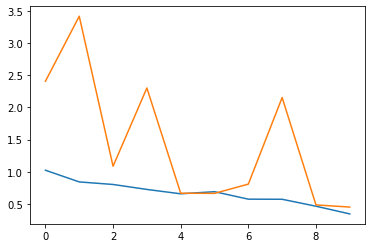

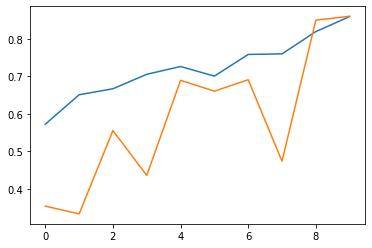

original train dataset length: 780
new train dataset length: 702


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 1.845560).   Saving model ...
Epoch : 1 Train Loss : 1.029347 Train Acc : 0.605519
Epoch : 1 test Loss : 1.845560 test Acc : 0.302083


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.845560 --> 1.420307).   Saving model ...
Epoch : 2 Train Loss : 0.837371 Train Acc : 0.643669
Epoch : 2 test Loss : 1.420307 test Acc : 0.375000


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.420307 --> 1.019695).   Saving model ...
Epoch : 3 Train Loss : 0.766888 Train Acc : 0.670860
Epoch : 3 test Loss : 1.019695 test Acc : 0.489583


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.019695 --> 0.863741).   Saving model ...
Epoch : 4 Train Loss : 0.743638 Train Acc : 0.676339
Epoch : 4 test Loss : 0.863741 test Acc : 0.554487


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.696770 Train Acc : 0.679789
Epoch : 5 test Loss : 0.969096 test Acc : 0.537660


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.738774 Train Acc : 0.674919
Epoch : 6 test Loss : 1.266164 test Acc : 0.541667


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.863741 --> 0.465961).   Saving model ...
Epoch : 7 Train Loss : 0.601378 Train Acc : 0.744724
Epoch : 7 test Loss : 0.465961 test Acc : 0.836538


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.531342 Train Acc : 0.777800
Epoch : 8 test Loss : 0.736202 test Acc : 0.677885


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.465961 --> 0.433277).   Saving model ...
Epoch : 9 Train Loss : 0.528699 Train Acc : 0.784700
Epoch : 9 test Loss : 0.433277 test Acc : 0.810897


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.433277 --> 0.346180).   Saving model ...
Epoch : 10 Train Loss : 0.491194 Train Acc : 0.787744
Epoch : 10 test Loss : 0.346180 test Acc : 0.862179


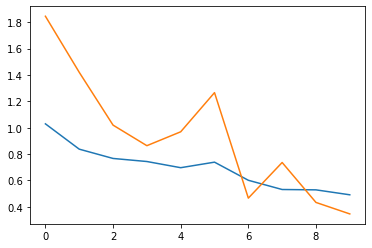

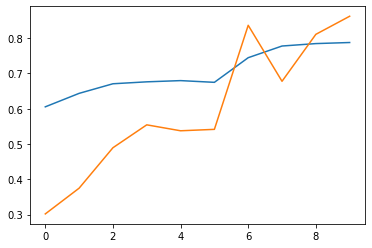

original train dataset length: 780
new train dataset length: 780


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 1.106323).   Saving model ...
Epoch : 1 Train Loss : 0.997302 Train Acc : 0.570578
Epoch : 1 test Loss : 1.106323 test Acc : 0.459135


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.864206 Train Acc : 0.619898
Epoch : 2 test Loss : 2.439401 test Acc : 0.338141


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.106323 --> 0.713862).   Saving model ...
Epoch : 3 Train Loss : 0.758104 Train Acc : 0.700255
Epoch : 3 test Loss : 0.713862 test Acc : 0.653846


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.695013 Train Acc : 0.703656
Epoch : 4 test Loss : 0.884762 test Acc : 0.603365


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.713862 --> 0.611676).   Saving model ...
Epoch : 5 Train Loss : 0.663254 Train Acc : 0.721514
Epoch : 5 test Loss : 0.611676 test Acc : 0.776442


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.558033 Train Acc : 0.767432
Epoch : 6 test Loss : 5.791848 test Acc : 0.322917


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.490894 Train Acc : 0.799320
Epoch : 7 test Loss : 1.098234 test Acc : 0.654647


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.611676 --> 0.505638).   Saving model ...
Epoch : 8 Train Loss : 0.499435 Train Acc : 0.791667
Epoch : 8 test Loss : 0.505638 test Acc : 0.822917


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.371102 Train Acc : 0.845238
Epoch : 9 test Loss : 0.621140 test Acc : 0.849359


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.505638 --> 0.276779).   Saving model ...
Epoch : 10 Train Loss : 0.324731 Train Acc : 0.875850
Epoch : 10 test Loss : 0.276779 test Acc : 0.867788


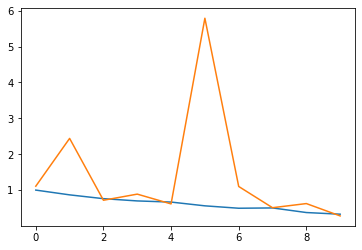

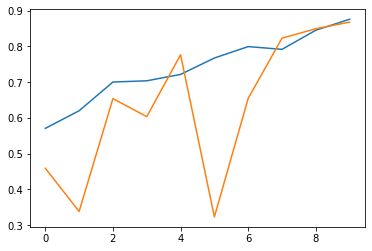

In [17]:
from torch.utils.data import random_split

for k in range(10,110,10):
    trainset = datasets.DatasetFolder(train_loc, transform = data_transform(TRAIN), loader=load_file, extensions="npy")
    testset = datasets.DatasetFolder(test_loc, transform = data_transform(TEST), loader=load_file, extensions="npy")
    
    len_us=len(trainset)
    len_train=int(k*len_us/100)
    len_val=len_us-len_train
    train_ds,val_ds=random_split(trainset,[len_train,len_val])

    print("original train dataset length:", len_us)
    print("new train dataset length:", len(train_ds))
    
    trainloader = DataLoader(train_ds,batch_size = 16,shuffle = True)
    testloader = DataLoader(testset,batch_size = 32,shuffle = False)
    
    model = models.resnet18(pretrained=False)
    model.fc = nn.Sequential(
        nn.Linear(512, 3),
        nn.LogSoftmax(dim=1) # For using NLLLoss()
    )

    for param in model.parameters():
        param.require_grad = True
    model.to(device);

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(),lr = 0.001)
    schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)
    
    training(trainloader, testloader, 10, f"rand_init_{k}")

### Pretrained = True

original train dataset length: 780
new train dataset length: 78


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 6.371338).   Saving model ...
Epoch : 1 Train Loss : 0.927630 Train Acc : 0.580357
Epoch : 1 test Loss : 6.371338 test Acc : 0.312500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.657362 Train Acc : 0.780357
Epoch : 2 test Loss : 18.342292 test Acc : 0.312500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.395672 Train Acc : 0.882143
Epoch : 3 test Loss : 21.842552 test Acc : 0.312500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.065295 Train Acc : 0.987500
Epoch : 4 test Loss : 16.869342 test Acc : 0.312500


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.090184 Train Acc : 0.960714
Epoch : 5 test Loss : 8.547471 test Acc : 0.322917


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.108659 Train Acc : 0.975000
Epoch : 6 test Loss : 9.327866 test Acc : 0.322917


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (6.371338 --> 5.184882).   Saving model ...
Epoch : 7 Train Loss : 0.098553 Train Acc : 0.950000
Epoch : 7 test Loss : 5.184882 test Acc : 0.411058


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (5.184882 --> 1.944500).   Saving model ...
Epoch : 8 Train Loss : 0.011105 Train Acc : 1.000000
Epoch : 8 test Loss : 1.944500 test Acc : 0.641026


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.944500 --> 1.799711).   Saving model ...
Epoch : 9 Train Loss : 0.046569 Train Acc : 0.975000
Epoch : 9 test Loss : 1.799711 test Acc : 0.586538


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.117574 Train Acc : 0.975000
Epoch : 10 test Loss : 2.659288 test Acc : 0.400641


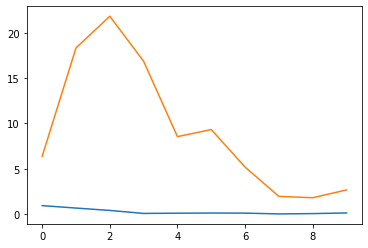

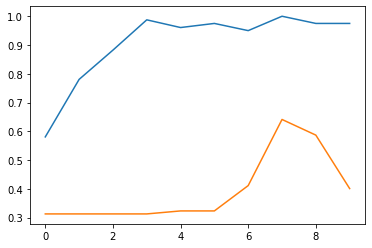

original train dataset length: 780
new train dataset length: 156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 3.226538).   Saving model ...
Epoch : 1 Train Loss : 1.149220 Train Acc : 0.614583
Epoch : 1 test Loss : 3.226538 test Acc : 0.547276


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.883614 Train Acc : 0.660417
Epoch : 2 test Loss : 20.055364 test Acc : 0.333333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (3.226538 --> 2.350563).   Saving model ...
Epoch : 3 Train Loss : 0.443753 Train Acc : 0.864583
Epoch : 3 test Loss : 2.350563 test Acc : 0.514423


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (2.350563 --> 0.989736).   Saving model ...
Epoch : 4 Train Loss : 0.290294 Train Acc : 0.910417
Epoch : 4 test Loss : 0.989736 test Acc : 0.697115


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.092391 Train Acc : 0.975000
Epoch : 5 test Loss : 1.005643 test Acc : 0.662660


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.061350 Train Acc : 0.985417
Epoch : 6 test Loss : 1.255411 test Acc : 0.677885


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.067624 Train Acc : 0.987500
Epoch : 7 test Loss : 2.844603 test Acc : 0.565705


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.989736 --> 0.955671).   Saving model ...
Epoch : 8 Train Loss : 0.176270 Train Acc : 0.943750
Epoch : 8 test Loss : 0.955671 test Acc : 0.786859


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.955671 --> 0.893040).   Saving model ...
Epoch : 9 Train Loss : 0.082977 Train Acc : 0.962500
Epoch : 9 test Loss : 0.893040 test Acc : 0.693910


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.076347 Train Acc : 0.981250
Epoch : 10 test Loss : 1.069266 test Acc : 0.701923


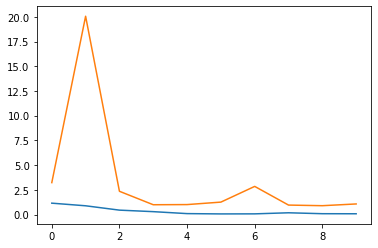

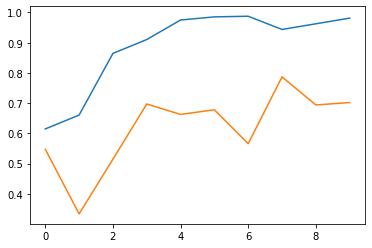

original train dataset length: 780
new train dataset length: 234


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 8.569379).   Saving model ...
Epoch : 1 Train Loss : 1.282047 Train Acc : 0.519167
Epoch : 1 test Loss : 8.569379 test Acc : 0.451923


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (8.569379 --> 1.561829).   Saving model ...
Epoch : 2 Train Loss : 0.686898 Train Acc : 0.736667
Epoch : 2 test Loss : 1.561829 test Acc : 0.551282


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.435993 Train Acc : 0.818333
Epoch : 3 test Loss : 1.821396 test Acc : 0.603365


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.561829 --> 0.755735).   Saving model ...
Epoch : 4 Train Loss : 0.253198 Train Acc : 0.916667
Epoch : 4 test Loss : 0.755735 test Acc : 0.673077


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.755735 --> 0.661213).   Saving model ...
Epoch : 5 Train Loss : 0.165112 Train Acc : 0.935000
Epoch : 5 test Loss : 0.661213 test Acc : 0.834135


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.123079 Train Acc : 0.954167
Epoch : 6 test Loss : 1.535825 test Acc : 0.612179


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.169188 Train Acc : 0.949167
Epoch : 7 test Loss : 1.547622 test Acc : 0.685897


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.153677 Train Acc : 0.945833
Epoch : 8 test Loss : 0.678925 test Acc : 0.818109


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.661213 --> 0.516483).   Saving model ...
Epoch : 9 Train Loss : 0.068977 Train Acc : 0.983333
Epoch : 9 test Loss : 0.516483 test Acc : 0.834135


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.051509 Train Acc : 0.991667
Epoch : 10 test Loss : 0.627772 test Acc : 0.826923


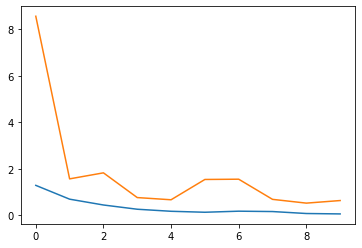

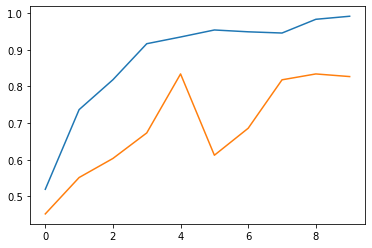

original train dataset length: 780
new train dataset length: 312


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 71.068376).   Saving model ...
Epoch : 1 Train Loss : 1.180697 Train Acc : 0.575000
Epoch : 1 test Loss : 71.068376 test Acc : 0.322917


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (71.068376 --> 1.571464).   Saving model ...
Epoch : 2 Train Loss : 0.591772 Train Acc : 0.750000
Epoch : 2 test Loss : 1.571464 test Acc : 0.586538


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.571464 --> 1.058299).   Saving model ...
Epoch : 3 Train Loss : 0.564451 Train Acc : 0.762500
Epoch : 3 test Loss : 1.058299 test Acc : 0.579327


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.058299 --> 0.660407).   Saving model ...
Epoch : 4 Train Loss : 0.320024 Train Acc : 0.878125
Epoch : 4 test Loss : 0.660407 test Acc : 0.724359


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.297908 Train Acc : 0.906250
Epoch : 5 test Loss : 2.311771 test Acc : 0.548878


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.660407 --> 0.648801).   Saving model ...
Epoch : 6 Train Loss : 0.337403 Train Acc : 0.875000
Epoch : 6 test Loss : 0.648801 test Acc : 0.725160


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.273275 Train Acc : 0.903125
Epoch : 7 test Loss : 0.660921 test Acc : 0.759615


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.170146 Train Acc : 0.934375
Epoch : 8 test Loss : 0.683728 test Acc : 0.758013


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.132585 Train Acc : 0.956250
Epoch : 9 test Loss : 0.659603 test Acc : 0.796474


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.170240 Train Acc : 0.940625
Epoch : 10 test Loss : 0.944403 test Acc : 0.717949


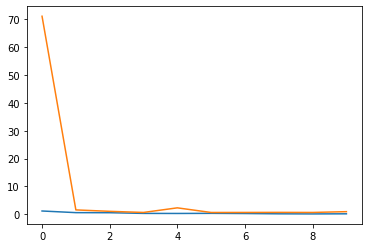

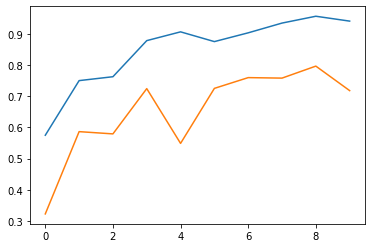

original train dataset length: 780
new train dataset length: 390


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 3.910083).   Saving model ...
Epoch : 1 Train Loss : 0.828555 Train Acc : 0.660000
Epoch : 1 test Loss : 3.910083 test Acc : 0.512821


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (3.910083 --> 0.684233).   Saving model ...
Epoch : 2 Train Loss : 0.416416 Train Acc : 0.829167
Epoch : 2 test Loss : 0.684233 test Acc : 0.766026


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.181442 Train Acc : 0.935833
Epoch : 3 test Loss : 1.090063 test Acc : 0.669872


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.684233 --> 0.327016).   Saving model ...
Epoch : 4 Train Loss : 0.286917 Train Acc : 0.890000
Epoch : 4 test Loss : 0.327016 test Acc : 0.873397


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.202284 Train Acc : 0.925833
Epoch : 5 test Loss : 0.626995 test Acc : 0.792468


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.142768 Train Acc : 0.942500
Epoch : 6 test Loss : 0.452562 test Acc : 0.838942


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.259245 Train Acc : 0.917500
Epoch : 7 test Loss : 0.677406 test Acc : 0.750801


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.137762 Train Acc : 0.965000
Epoch : 8 test Loss : 0.552279 test Acc : 0.852564


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.089533 Train Acc : 0.975000
Epoch : 9 test Loss : 0.454931 test Acc : 0.838942


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.083979 Train Acc : 0.962500
Epoch : 10 test Loss : 1.219377 test Acc : 0.741186


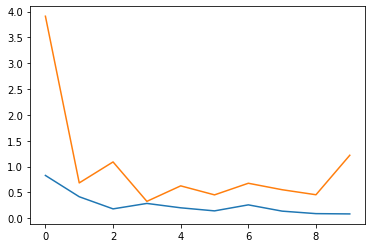

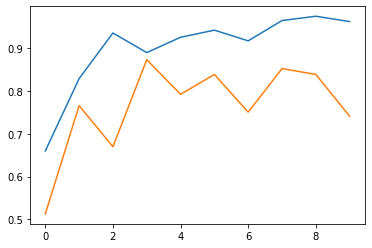

original train dataset length: 780
new train dataset length: 468


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 33.984364).   Saving model ...
Epoch : 1 Train Loss : 0.820243 Train Acc : 0.695833
Epoch : 1 test Loss : 33.984364 test Acc : 0.302083


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (33.984364 --> 1.291944).   Saving model ...
Epoch : 2 Train Loss : 0.532748 Train Acc : 0.783333
Epoch : 2 test Loss : 1.291944 test Acc : 0.628205


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.291944 --> 0.642347).   Saving model ...
Epoch : 3 Train Loss : 0.386219 Train Acc : 0.827083
Epoch : 3 test Loss : 0.642347 test Acc : 0.734776


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.288779 Train Acc : 0.879167
Epoch : 4 test Loss : 0.845248 test Acc : 0.816506


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.642347 --> 0.315993).   Saving model ...
Epoch : 5 Train Loss : 0.262567 Train Acc : 0.906250
Epoch : 5 test Loss : 0.315993 test Acc : 0.878205


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.358263 Train Acc : 0.883333
Epoch : 6 test Loss : 0.456167 test Acc : 0.787660


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.264899 Train Acc : 0.887500
Epoch : 7 test Loss : 0.544942 test Acc : 0.824519


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.315993 --> 0.312517).   Saving model ...
Epoch : 8 Train Loss : 0.265995 Train Acc : 0.916667
Epoch : 8 test Loss : 0.312517 test Acc : 0.870192


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.312517 --> 0.265492).   Saving model ...
Epoch : 9 Train Loss : 0.197953 Train Acc : 0.931250
Epoch : 9 test Loss : 0.265492 test Acc : 0.896635


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.265492 --> 0.236998).   Saving model ...
Epoch : 10 Train Loss : 0.092416 Train Acc : 0.966667
Epoch : 10 test Loss : 0.236998 test Acc : 0.927083


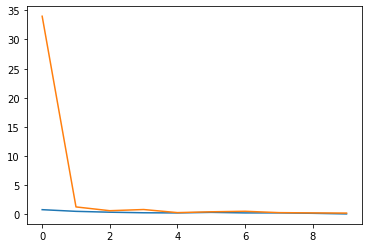

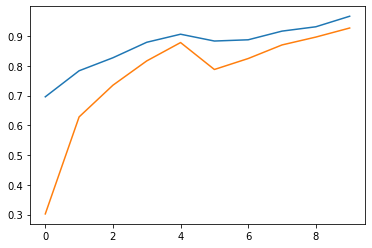

original train dataset length: 780
new train dataset length: 546


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 34.902986).   Saving model ...
Epoch : 1 Train Loss : 0.833408 Train Acc : 0.682143
Epoch : 1 test Loss : 34.902986 test Acc : 0.364583


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (34.902986 --> 0.530787).   Saving model ...
Epoch : 2 Train Loss : 0.634349 Train Acc : 0.739286
Epoch : 2 test Loss : 0.530787 test Acc : 0.820513


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.530787 --> 0.435156).   Saving model ...
Epoch : 3 Train Loss : 0.359418 Train Acc : 0.860714
Epoch : 3 test Loss : 0.435156 test Acc : 0.806090


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.260681 Train Acc : 0.900000
Epoch : 4 test Loss : 1.326523 test Acc : 0.680288


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.381857 Train Acc : 0.851786
Epoch : 5 test Loss : 1.297431 test Acc : 0.566506


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.449056 Train Acc : 0.830357
Epoch : 6 test Loss : 0.765680 test Acc : 0.713942


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.260023 Train Acc : 0.910714
Epoch : 7 test Loss : 0.605511 test Acc : 0.741186


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.294447 Train Acc : 0.878571
Epoch : 8 test Loss : 1.183830 test Acc : 0.673077


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.435156 --> 0.158519).   Saving model ...
Epoch : 9 Train Loss : 0.195164 Train Acc : 0.928571
Epoch : 9 test Loss : 0.158519 test Acc : 0.968750


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.248910 Train Acc : 0.919643
Epoch : 10 test Loss : 0.984766 test Acc : 0.833333


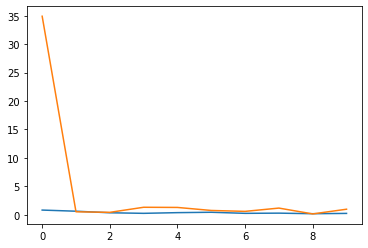

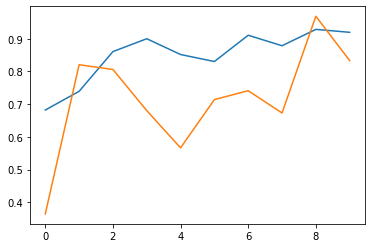

original train dataset length: 780
new train dataset length: 624


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 4.858242).   Saving model ...
Epoch : 1 Train Loss : 0.936453 Train Acc : 0.613782
Epoch : 1 test Loss : 4.858242 test Acc : 0.454327


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (4.858242 --> 0.351719).   Saving model ...
Epoch : 2 Train Loss : 0.507511 Train Acc : 0.782051
Epoch : 2 test Loss : 0.351719 test Acc : 0.883814


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.364853 Train Acc : 0.857372
Epoch : 3 test Loss : 0.449768 test Acc : 0.799679


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.351719 --> 0.208846).   Saving model ...
Epoch : 4 Train Loss : 0.256750 Train Acc : 0.905449
Epoch : 4 test Loss : 0.208846 test Acc : 0.955929


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.232703 Train Acc : 0.905449
Epoch : 5 test Loss : 0.290280 test Acc : 0.894231


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.174171 Train Acc : 0.934295
Epoch : 6 test Loss : 0.217626 test Acc : 0.901442


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.213976 Train Acc : 0.924679
Epoch : 7 test Loss : 0.286614 test Acc : 0.881410


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.208846 --> 0.172179).   Saving model ...
Epoch : 8 Train Loss : 0.164990 Train Acc : 0.950321
Epoch : 8 test Loss : 0.172179 test Acc : 0.932692


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.111786 Train Acc : 0.961538
Epoch : 9 test Loss : 0.330101 test Acc : 0.912660


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.271809 Train Acc : 0.903846
Epoch : 10 test Loss : 0.210617 test Acc : 0.903846


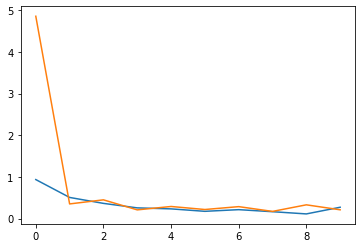

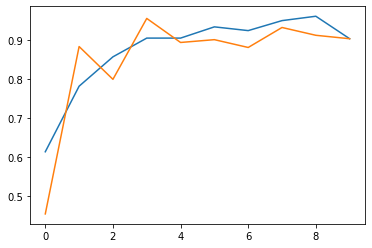

original train dataset length: 780
new train dataset length: 702


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 0.802112).   Saving model ...
Epoch : 1 Train Loss : 0.892012 Train Acc : 0.641234
Epoch : 1 test Loss : 0.802112 test Acc : 0.661859


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.802112 --> 0.751875).   Saving model ...
Epoch : 2 Train Loss : 0.464510 Train Acc : 0.811688
Epoch : 2 test Loss : 0.751875 test Acc : 0.711538


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.751875 --> 0.324597).   Saving model ...
Epoch : 3 Train Loss : 0.366603 Train Acc : 0.858766
Epoch : 3 test Loss : 0.324597 test Acc : 0.872596


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.324597 --> 0.164972).   Saving model ...
Epoch : 4 Train Loss : 0.291106 Train Acc : 0.891640
Epoch : 4 test Loss : 0.164972 test Acc : 0.927083


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.264569 Train Acc : 0.916193
Epoch : 5 test Loss : 0.396717 test Acc : 0.849359


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.164972 --> 0.069429).   Saving model ...
Epoch : 6 Train Loss : 0.214702 Train Acc : 0.925528
Epoch : 6 test Loss : 0.069429 test Acc : 0.989583


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.136392 Train Acc : 0.955763
Epoch : 7 test Loss : 0.280573 test Acc : 0.876603


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.156196 Train Acc : 0.941558
Epoch : 8 test Loss : 0.352751 test Acc : 0.842949


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.129623 Train Acc : 0.950081
Epoch : 9 test Loss : 0.225155 test Acc : 0.909455


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.115471 Train Acc : 0.956778
Epoch : 10 test Loss : 0.123073 test Acc : 0.940705


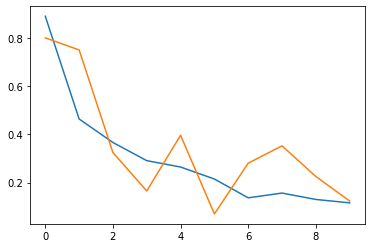

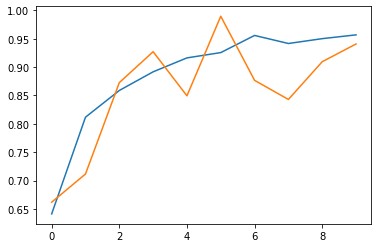

original train dataset length: 780
new train dataset length: 780


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 1.782517).   Saving model ...
Epoch : 1 Train Loss : 0.867900 Train Acc : 0.648384
Epoch : 1 test Loss : 1.782517 test Acc : 0.408654


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.782517 --> 0.354154).   Saving model ...
Epoch : 2 Train Loss : 0.523280 Train Acc : 0.796344
Epoch : 2 test Loss : 0.354154 test Acc : 0.883013


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.418000 Train Acc : 0.816327
Epoch : 3 test Loss : 2.179895 test Acc : 0.369391


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.318715 Train Acc : 0.881378
Epoch : 4 test Loss : 0.936497 test Acc : 0.750000


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.354154 --> 0.057523).   Saving model ...
Epoch : 5 Train Loss : 0.279841 Train Acc : 0.909439
Epoch : 5 test Loss : 0.057523 test Acc : 0.989583


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.226983 Train Acc : 0.918792
Epoch : 6 test Loss : 0.336266 test Acc : 0.870994


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.203287 Train Acc : 0.926446
Epoch : 7 test Loss : 0.155730 test Acc : 0.958333


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.157347 Train Acc : 0.945153
Epoch : 8 test Loss : 0.183214 test Acc : 0.932692


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.209501 Train Acc : 0.920493
Epoch : 9 test Loss : 0.060418 test Acc : 0.989583


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.057523 --> 0.025464).   Saving model ...
Epoch : 10 Train Loss : 0.105145 Train Acc : 0.967687
Epoch : 10 test Loss : 0.025464 test Acc : 1.000000


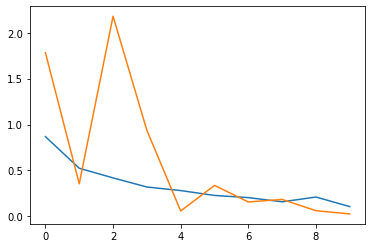

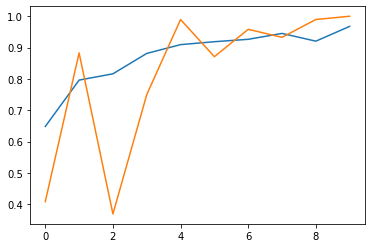

In [18]:
from torch.utils.data import random_split

for k in range(10,110,10):
    trainset = datasets.DatasetFolder(train_loc, transform = data_transform(TRAIN), loader=load_file, extensions="npy")
    testset = datasets.DatasetFolder(test_loc, transform = data_transform(TEST), loader=load_file, extensions="npy")
    
    len_us=len(trainset)
    len_train=int(k*len_us/100)
    len_val=len_us-len_train
    train_ds,val_ds=random_split(trainset,[len_train,len_val])

    print("original train dataset length:", len_us)
    print("new train dataset length:", len(train_ds))
    
    trainloader = DataLoader(train_ds,batch_size = 16,shuffle = True)
    testloader = DataLoader(testset,batch_size = 32,shuffle = False)
    
    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Linear(512, 3),
        nn.LogSoftmax(dim=1) # For using NLLLoss()
    )

    for param in model.parameters():
        param.require_grad = True
    model.to(device);

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(),lr = 0.001)
    schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)
    
    training(trainloader, testloader, 10, f"ImageNet_init_{k}")

### SSL-pretraining: Rotation

### Creating the dataset

In [41]:
from PIL import Image

os.makedirs("./rotate", exist_ok=True)
os.makedirs("./rotate/train/", exist_ok=True)
os.makedirs("./rotate/test/", exist_ok=True)
class_names = ['0','45','-45','30','-30', '90', '180', '270']
for i in class_names:
    os.makedirs(f"./rotate/train/{i}", exist_ok=True)
    os.makedirs(f"./rotate/test/{i}", exist_ok=True)
    
    
for i in tqdm(train_file_paths):
    for c in class_names:
        a = Image.open(i)
        a = a.resize((224,224))
        a = a.rotate(int(c))
        a = np.array(a)
        np.save(f"./rotate/train/{c}/{i.split('/')[-1][:-4]}.npy", a)


for i in tqdm(test_file_paths):
    for c in class_names:
        a = Image.open(i)
        a = a.resize((224,224))
        a = a.rotate(int(c))
        a = np.array(a)
        np.save(f"./rotate/test/{c}/{i.split('/')[-1][:-4]}.npy", a)

  0%|          | 0/780 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

### Training

In [42]:
train_loc = "./rotate/train/"
test_loc = "./rotate/test/"
def load_file(path):
    return np.load(path).astype(np.float32)

In [43]:
TRAIN = 'train'
TEST = 'test'
def data_transform(phase = None):
    if phase == TRAIN:
        data_T = T.Compose([
            T.ToTensor(),
            T.Normalize([83.6046, 83.6027, 83.5871],[56.0671, 56.0670, 56.0605])
        ])
        
    elif phase == TEST:
        data_T = T.Compose([
            T.ToTensor(), 
            T.Normalize([83.6046, 83.6027, 83.5871],[56.0671, 56.0670, 56.0605])
        ])
    return data_T

trainset = datasets.DatasetFolder(train_loc, transform = data_transform(TRAIN), loader=load_file, extensions="npy")
testset = datasets.DatasetFolder(test_loc, transform = data_transform(TEST), loader=load_file, extensions="npy")

In [44]:
class_name = trainset.classes
print(class_name)
print(trainset.class_to_idx)

['-30', '-45', '0', '180', '270', '30', '45', '90']
{'-30': 0, '-45': 1, '0': 2, '180': 3, '270': 4, '30': 5, '45': 6, '90': 7}


  0%|          | 0/6240 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Train_set')

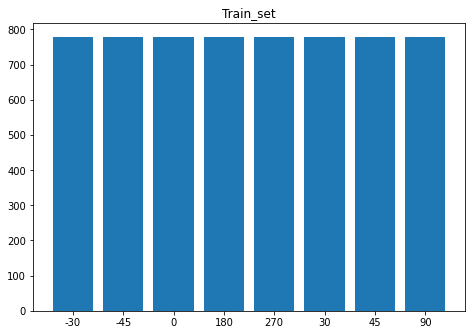

In [48]:
def get_class_count(dataset):
    class_name = dataset.classes
    classes = []
    for _,labels in tqdm(dataset):
        classes.append(class_name[labels])
    return classes

count = get_class_count(trainset)
unique, counts = np.unique(count, return_counts=True)
dict(zip(unique, counts))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(unique,counts)
ax.set_title("Train_set")

In [49]:
trainloader = DataLoader(trainset,batch_size = 16,shuffle = True)
testloader = DataLoader(testset,batch_size = 64,shuffle = False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [50]:
model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(512, 8),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

for param in model.parameters():
    param.require_grad = True
model.to(device);

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)

In [51]:
def accuracy(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Test loss decreased (inf --> 0.020329).   Saving model ...
Epoch : 1 Train Loss : 0.149526 Train Acc : 0.961058
Epoch : 1 test Loss : 0.020329 test Acc : 0.992188


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Test loss decreased (0.020329 --> 0.009189).   Saving model ...
Epoch : 2 Train Loss : 0.024786 Train Acc : 0.994231
Epoch : 2 test Loss : 0.009189 test Acc : 0.997396


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Test loss decreased (0.009189 --> 0.002761).   Saving model ...
Epoch : 3 Train Loss : 0.014038 Train Acc : 0.996314
Epoch : 3 test Loss : 0.002761 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.003306 Train Acc : 0.999359
Epoch : 4 test Loss : 0.016184 test Acc : 0.998698


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.009784 Train Acc : 0.997596
Epoch : 5 test Loss : 0.002791 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Test loss decreased (0.002761 --> 0.001029).   Saving model ...
Epoch : 6 Train Loss : 0.010223 Train Acc : 0.997917
Epoch : 6 test Loss : 0.001029 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Test loss decreased (0.001029 --> 0.001025).   Saving model ...
Epoch : 7 Train Loss : 0.006703 Train Acc : 0.998558
Epoch : 7 test Loss : 0.001025 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.003858 Train Acc : 0.998878
Epoch : 8 test Loss : 0.001812 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Test loss decreased (0.001025 --> 0.000294).   Saving model ...
Epoch : 9 Train Loss : 0.006326 Train Acc : 0.998077
Epoch : 9 test Loss : 0.000294 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.011793 Train Acc : 0.996154
Epoch : 10 test Loss : 0.027815 test Acc : 0.993490


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Test loss decreased (0.000294 --> 0.000181).   Saving model ...
Epoch : 11 Train Loss : 0.006037 Train Acc : 0.998237
Epoch : 11 test Loss : 0.000181 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.008943 Train Acc : 0.996635
Epoch : 12 test Loss : 0.003661 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.004218 Train Acc : 0.999038
Epoch : 13 test Loss : 0.000462 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Test loss decreased (0.000181 --> 0.000097).   Saving model ...
Epoch : 14 Train Loss : 0.003432 Train Acc : 0.999199
Epoch : 14 test Loss : 0.000097 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.002217 Train Acc : 0.999359
Epoch : 15 test Loss : 0.000773 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Test loss decreased (0.000097 --> 0.000072).   Saving model ...
Epoch : 16 Train Loss : 0.003001 Train Acc : 0.999199
Epoch : 16 test Loss : 0.000072 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.002273 Train Acc : 0.999359
Epoch : 17 test Loss : 0.000209 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Test loss decreased (0.000072 --> 0.000019).   Saving model ...
Epoch : 18 Train Loss : 0.000477 Train Acc : 1.000000
Epoch : 18 test Loss : 0.000019 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.000940 Train Acc : 1.000000
Epoch : 19 test Loss : 0.000330 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.001679 Train Acc : 0.999359
Epoch : 20 test Loss : 0.000201 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 21 Train Loss : 0.013975 Train Acc : 0.995673
Epoch : 21 test Loss : 0.000284 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 0.002225 Train Acc : 0.999359
Epoch : 22 test Loss : 0.000053 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 23 Train Loss : 0.002497 Train Acc : 0.999038
Epoch : 23 test Loss : 0.000178 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 0.000535 Train Acc : 0.999840
Epoch : 24 test Loss : 0.000049 test Acc : 1.000000


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 0.000328 Train Acc : 0.999840
Epoch : 25 test Loss : 0.000060 test Acc : 1.000000


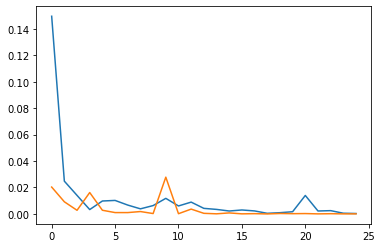

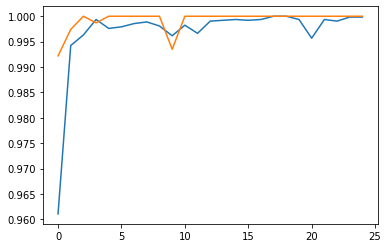

In [52]:
training(trainloader, testloader, 25, f"ssl_init_weights_rotation")

### Trained_using_SSL

original train dataset length: 780
new train dataset length: 78


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 1.116670).   Saving model ...
Epoch : 1 Train Loss : 1.164746 Train Acc : 0.308929
Epoch : 1 test Loss : 1.116670 test Acc : 0.395833


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.705373 Train Acc : 0.730357
Epoch : 2 test Loss : 1.244642 test Acc : 0.346154


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.571986 Train Acc : 0.769643
Epoch : 3 test Loss : 1.363873 test Acc : 0.371795


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.116670 --> 1.101187).   Saving model ...
Epoch : 4 Train Loss : 0.444814 Train Acc : 0.828571
Epoch : 4 test Loss : 1.101187 test Acc : 0.516026


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.101187 --> 0.969029).   Saving model ...
Epoch : 5 Train Loss : 0.279999 Train Acc : 0.923214
Epoch : 5 test Loss : 0.969029 test Acc : 0.552083


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.182228 Train Acc : 0.973214
Epoch : 6 test Loss : 1.279039 test Acc : 0.482372


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.116052 Train Acc : 1.000000
Epoch : 7 test Loss : 1.239177 test Acc : 0.498397


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.059678 Train Acc : 1.000000
Epoch : 8 test Loss : 1.298210 test Acc : 0.537660


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.032481 Train Acc : 1.000000
Epoch : 9 test Loss : 1.340248 test Acc : 0.558494


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.050021 Train Acc : 1.000000
Epoch : 10 test Loss : 1.703315 test Acc : 0.454327


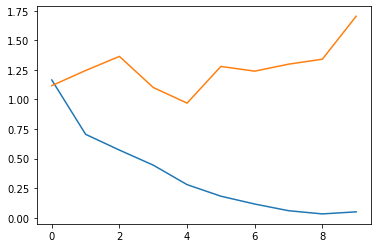

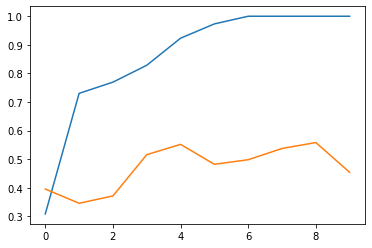

original train dataset length: 780
new train dataset length: 156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 1.439922).   Saving model ...
Epoch : 1 Train Loss : 0.882550 Train Acc : 0.614583
Epoch : 1 test Loss : 1.439922 test Acc : 0.322917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.439922 --> 1.217208).   Saving model ...
Epoch : 2 Train Loss : 0.707727 Train Acc : 0.710417
Epoch : 2 test Loss : 1.217208 test Acc : 0.392628


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.217208 --> 1.149070).   Saving model ...
Epoch : 3 Train Loss : 0.496603 Train Acc : 0.841667
Epoch : 3 test Loss : 1.149070 test Acc : 0.500801


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.149070 --> 0.909607).   Saving model ...
Epoch : 4 Train Loss : 0.330017 Train Acc : 0.912500
Epoch : 4 test Loss : 0.909607 test Acc : 0.609776


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.909607 --> 0.774141).   Saving model ...
Epoch : 5 Train Loss : 0.166112 Train Acc : 0.962500
Epoch : 5 test Loss : 0.774141 test Acc : 0.669071


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.091106 Train Acc : 0.987500
Epoch : 6 test Loss : 0.900850 test Acc : 0.629808


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.044345 Train Acc : 1.000000
Epoch : 7 test Loss : 0.896058 test Acc : 0.637821


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.020764 Train Acc : 1.000000
Epoch : 8 test Loss : 0.959949 test Acc : 0.635417


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.029774 Train Acc : 1.000000
Epoch : 9 test Loss : 1.050034 test Acc : 0.669071


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.013460 Train Acc : 1.000000
Epoch : 10 test Loss : 1.086325 test Acc : 0.661058


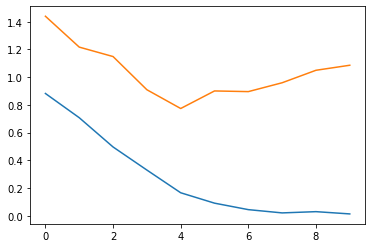

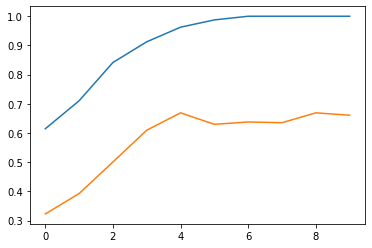

original train dataset length: 780
new train dataset length: 234


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 1.312427).   Saving model ...
Epoch : 1 Train Loss : 1.142064 Train Acc : 0.480000
Epoch : 1 test Loss : 1.312427 test Acc : 0.343750


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.312427 --> 0.956394).   Saving model ...
Epoch : 2 Train Loss : 0.746134 Train Acc : 0.665833
Epoch : 2 test Loss : 0.956394 test Acc : 0.426282


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.956394 --> 0.788757).   Saving model ...
Epoch : 3 Train Loss : 0.608905 Train Acc : 0.760833
Epoch : 3 test Loss : 0.788757 test Acc : 0.661058


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.788757 --> 0.757991).   Saving model ...
Epoch : 4 Train Loss : 0.421214 Train Acc : 0.857500
Epoch : 4 test Loss : 0.757991 test Acc : 0.623397


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.757991 --> 0.621639).   Saving model ...
Epoch : 5 Train Loss : 0.250965 Train Acc : 0.918333
Epoch : 5 test Loss : 0.621639 test Acc : 0.719551


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.127468 Train Acc : 0.970833
Epoch : 6 test Loss : 0.673860 test Acc : 0.754006


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.059412 Train Acc : 0.987500
Epoch : 7 test Loss : 0.750798 test Acc : 0.712340


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.033615 Train Acc : 0.995833
Epoch : 8 test Loss : 0.672895 test Acc : 0.774840


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.071341 Train Acc : 0.974167
Epoch : 9 test Loss : 0.817985 test Acc : 0.754006


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.045565 Train Acc : 0.991667
Epoch : 10 test Loss : 0.752364 test Acc : 0.737981


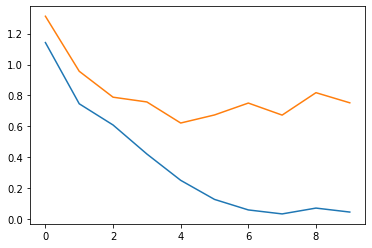

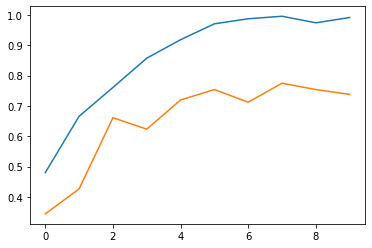

original train dataset length: 780
new train dataset length: 312


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 1.166707).   Saving model ...
Epoch : 1 Train Loss : 1.034796 Train Acc : 0.506250
Epoch : 1 test Loss : 1.166707 test Acc : 0.354167


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.166707 --> 1.031267).   Saving model ...
Epoch : 2 Train Loss : 0.700342 Train Acc : 0.687500
Epoch : 2 test Loss : 1.031267 test Acc : 0.408654


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (1.031267 --> 0.961637).   Saving model ...
Epoch : 3 Train Loss : 0.530455 Train Acc : 0.778125
Epoch : 3 test Loss : 0.961637 test Acc : 0.569712


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.961637 --> 0.897285).   Saving model ...
Epoch : 4 Train Loss : 0.305842 Train Acc : 0.921875
Epoch : 4 test Loss : 0.897285 test Acc : 0.558494


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.897285 --> 0.759883).   Saving model ...
Epoch : 5 Train Loss : 0.163709 Train Acc : 0.968750
Epoch : 5 test Loss : 0.759883 test Acc : 0.681891


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.759883 --> 0.560110).   Saving model ...
Epoch : 6 Train Loss : 0.091257 Train Acc : 0.978125
Epoch : 6 test Loss : 0.560110 test Acc : 0.735577


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.054122 Train Acc : 0.987500
Epoch : 7 test Loss : 0.666127 test Acc : 0.722756


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.560110 --> 0.542339).   Saving model ...
Epoch : 8 Train Loss : 0.023740 Train Acc : 1.000000
Epoch : 8 test Loss : 0.542339 test Acc : 0.806090


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.032039 Train Acc : 0.996875
Epoch : 9 test Loss : 0.672445 test Acc : 0.754006


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.012297 Train Acc : 1.000000
Epoch : 10 test Loss : 0.744155 test Acc : 0.741186


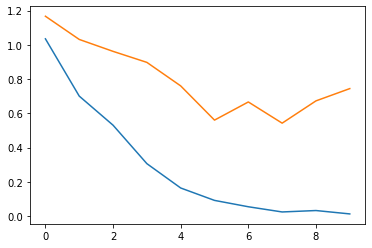

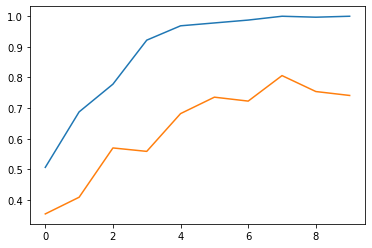

original train dataset length: 780
new train dataset length: 390


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 0.909130).   Saving model ...
Epoch : 1 Train Loss : 0.874772 Train Acc : 0.590833
Epoch : 1 test Loss : 0.909130 test Acc : 0.523237


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.665813 Train Acc : 0.727500
Epoch : 2 test Loss : 0.955285 test Acc : 0.506410


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.909130 --> 0.587400).   Saving model ...
Epoch : 3 Train Loss : 0.450009 Train Acc : 0.823333
Epoch : 3 test Loss : 0.587400 test Acc : 0.798878


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.587400 --> 0.338059).   Saving model ...
Epoch : 4 Train Loss : 0.283495 Train Acc : 0.909167
Epoch : 4 test Loss : 0.338059 test Acc : 0.899038


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.194017 Train Acc : 0.931667
Epoch : 5 test Loss : 0.526806 test Acc : 0.834936


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.121586 Train Acc : 0.960000
Epoch : 6 test Loss : 0.379874 test Acc : 0.907051


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.064788 Train Acc : 0.985000
Epoch : 7 test Loss : 0.401694 test Acc : 0.870994


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.045815 Train Acc : 0.990000
Epoch : 8 test Loss : 0.525543 test Acc : 0.855769


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.338059 --> 0.265100).   Saving model ...
Epoch : 9 Train Loss : 0.049822 Train Acc : 0.990000
Epoch : 9 test Loss : 0.265100 test Acc : 0.896635


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.029485 Train Acc : 0.995000
Epoch : 10 test Loss : 0.514500 test Acc : 0.855769


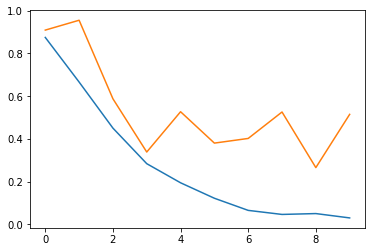

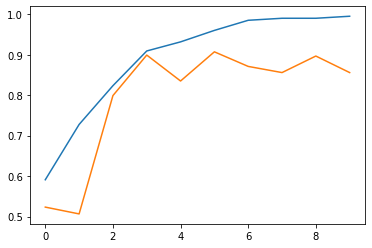

original train dataset length: 780
new train dataset length: 468


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 0.773382).   Saving model ...
Epoch : 1 Train Loss : 0.858889 Train Acc : 0.616667
Epoch : 1 test Loss : 0.773382 test Acc : 0.653045


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.773382 --> 0.656196).   Saving model ...
Epoch : 2 Train Loss : 0.640747 Train Acc : 0.729167
Epoch : 2 test Loss : 0.656196 test Acc : 0.734776


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.425955 Train Acc : 0.818750
Epoch : 3 test Loss : 0.697494 test Acc : 0.707532


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.656196 --> 0.462997).   Saving model ...
Epoch : 4 Train Loss : 0.271469 Train Acc : 0.904167
Epoch : 4 test Loss : 0.462997 test Acc : 0.826122


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.462997 --> 0.378785).   Saving model ...
Epoch : 5 Train Loss : 0.146432 Train Acc : 0.962500
Epoch : 5 test Loss : 0.378785 test Acc : 0.896635


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.057696 Train Acc : 0.989583
Epoch : 6 test Loss : 0.411583 test Acc : 0.886218


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.023021 Train Acc : 0.997917
Epoch : 7 test Loss : 0.417696 test Acc : 0.852564


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.021080 Train Acc : 0.997917
Epoch : 8 test Loss : 0.503103 test Acc : 0.883814


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.023530 Train Acc : 0.995833
Epoch : 9 test Loss : 0.394522 test Acc : 0.888622


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.062899 Train Acc : 0.981250
Epoch : 10 test Loss : 0.570509 test Acc : 0.798077


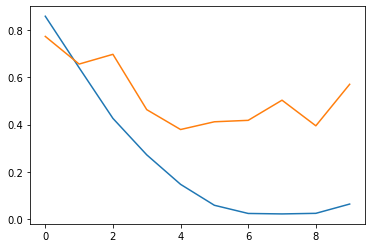

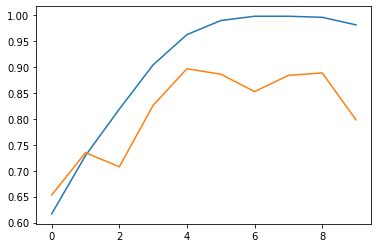

original train dataset length: 780
new train dataset length: 546


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 0.721542).   Saving model ...
Epoch : 1 Train Loss : 0.909934 Train Acc : 0.583929
Epoch : 1 test Loss : 0.721542 test Acc : 0.691506


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.699691 Train Acc : 0.705357
Epoch : 2 test Loss : 0.922648 test Acc : 0.586538


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.721542 --> 0.560878).   Saving model ...
Epoch : 3 Train Loss : 0.542642 Train Acc : 0.776786
Epoch : 3 test Loss : 0.560878 test Acc : 0.760417


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.560878 --> 0.357226).   Saving model ...
Epoch : 4 Train Loss : 0.324750 Train Acc : 0.903571
Epoch : 4 test Loss : 0.357226 test Acc : 0.862981


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.357226 --> 0.188555).   Saving model ...
Epoch : 5 Train Loss : 0.182476 Train Acc : 0.930357
Epoch : 5 test Loss : 0.188555 test Acc : 0.930288


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.122209 Train Acc : 0.958929
Epoch : 6 test Loss : 0.212015 test Acc : 0.922276


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.188555 --> 0.187287).   Saving model ...
Epoch : 7 Train Loss : 0.081314 Train Acc : 0.978571
Epoch : 7 test Loss : 0.187287 test Acc : 0.947917


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.187287 --> 0.169661).   Saving model ...
Epoch : 8 Train Loss : 0.143738 Train Acc : 0.951786
Epoch : 8 test Loss : 0.169661 test Acc : 0.922276


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.063693 Train Acc : 0.987500
Epoch : 9 test Loss : 0.229046 test Acc : 0.932692


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.048927 Train Acc : 0.987500
Epoch : 10 test Loss : 0.188174 test Acc : 0.953526


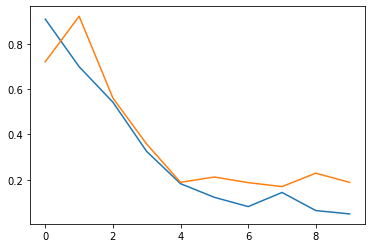

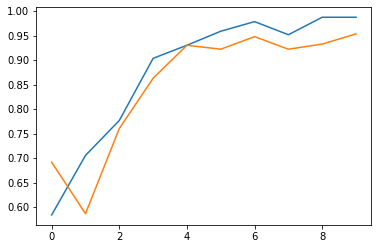

original train dataset length: 780
new train dataset length: 624


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 0.850466).   Saving model ...
Epoch : 1 Train Loss : 0.890568 Train Acc : 0.602564
Epoch : 1 test Loss : 0.850466 test Acc : 0.493590


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.645704 Train Acc : 0.746795
Epoch : 2 test Loss : 0.857607 test Acc : 0.568109


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.850466 --> 0.251361).   Saving model ...
Epoch : 3 Train Loss : 0.460598 Train Acc : 0.806090
Epoch : 3 test Loss : 0.251361 test Acc : 0.901442


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.251361 --> 0.156026).   Saving model ...
Epoch : 4 Train Loss : 0.233390 Train Acc : 0.934295
Epoch : 4 test Loss : 0.156026 test Acc : 0.968750


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.156026 --> 0.101380).   Saving model ...
Epoch : 5 Train Loss : 0.124637 Train Acc : 0.964744
Epoch : 5 test Loss : 0.101380 test Acc : 0.974359


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.101380 --> 0.054195).   Saving model ...
Epoch : 6 Train Loss : 0.069762 Train Acc : 0.983974
Epoch : 6 test Loss : 0.054195 test Acc : 0.979167


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.070373 Train Acc : 0.979167
Epoch : 7 test Loss : 0.083210 test Acc : 0.974359


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.051474 Train Acc : 0.987179
Epoch : 8 test Loss : 0.058478 test Acc : 0.976763


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.039639 Train Acc : 0.993590
Epoch : 9 test Loss : 0.085339 test Acc : 0.966346


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.081138 Train Acc : 0.977564
Epoch : 10 test Loss : 0.308313 test Acc : 0.873397


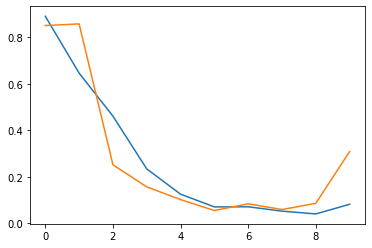

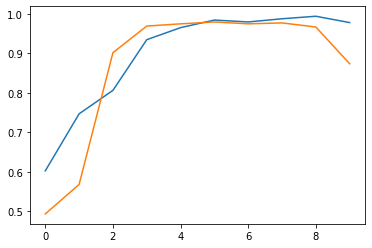

original train dataset length: 780
new train dataset length: 702


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 0.640776).   Saving model ...
Epoch : 1 Train Loss : 0.836193 Train Acc : 0.624188
Epoch : 1 test Loss : 0.640776 test Acc : 0.721955


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.640776 --> 0.412415).   Saving model ...
Epoch : 2 Train Loss : 0.557065 Train Acc : 0.779221
Epoch : 2 test Loss : 0.412415 test Acc : 0.862179


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.412415 --> 0.271610).   Saving model ...
Epoch : 3 Train Loss : 0.335234 Train Acc : 0.857346
Epoch : 3 test Loss : 0.271610 test Acc : 0.888622


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.271610 --> 0.246155).   Saving model ...
Epoch : 4 Train Loss : 0.191323 Train Acc : 0.936080
Epoch : 4 test Loss : 0.246155 test Acc : 0.909455


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.246155 --> 0.070625).   Saving model ...
Epoch : 5 Train Loss : 0.112315 Train Acc : 0.970170
Epoch : 5 test Loss : 0.070625 test Acc : 0.968750


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.070625 --> 0.033165).   Saving model ...
Epoch : 6 Train Loss : 0.070266 Train Acc : 0.975852
Epoch : 6 test Loss : 0.033165 test Acc : 0.989583


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.079733 Train Acc : 0.984375
Epoch : 7 test Loss : 0.055452 test Acc : 0.976763


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.050909 Train Acc : 0.984172
Epoch : 8 test Loss : 0.070347 test Acc : 0.976763


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.065301 Train Acc : 0.981534
Epoch : 9 test Loss : 0.045913 test Acc : 0.989583


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.051628 Train Acc : 0.985795
Epoch : 10 test Loss : 0.069891 test Acc : 0.966346


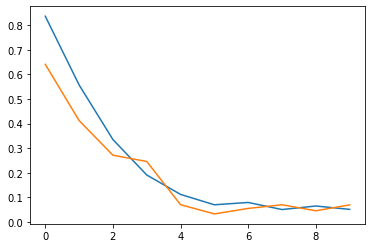

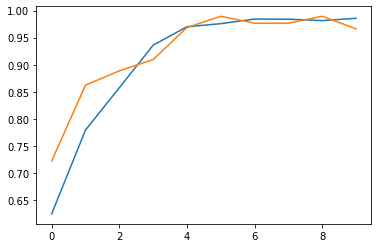

original train dataset length: 780
new train dataset length: 780


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (inf --> 0.794423).   Saving model ...
Epoch : 1 Train Loss : 0.837971 Train Acc : 0.634354
Epoch : 1 test Loss : 0.794423 test Acc : 0.657853


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.794423 --> 0.524403).   Saving model ...
Epoch : 2 Train Loss : 0.579268 Train Acc : 0.773810
Epoch : 2 test Loss : 0.524403 test Acc : 0.745192


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.524403 --> 0.268777).   Saving model ...
Epoch : 3 Train Loss : 0.447211 Train Acc : 0.809949
Epoch : 3 test Loss : 0.268777 test Acc : 0.911859


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.268777 --> 0.137023).   Saving model ...
Epoch : 4 Train Loss : 0.260222 Train Acc : 0.920918
Epoch : 4 test Loss : 0.137023 test Acc : 0.963942


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.137023 --> 0.064811).   Saving model ...
Epoch : 5 Train Loss : 0.136095 Train Acc : 0.963861
Epoch : 5 test Loss : 0.064811 test Acc : 0.989583


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.064811 --> 0.043820).   Saving model ...
Epoch : 6 Train Loss : 0.118683 Train Acc : 0.965986
Epoch : 6 test Loss : 0.043820 test Acc : 0.979167


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.043820 --> 0.024349).   Saving model ...
Epoch : 7 Train Loss : 0.075090 Train Acc : 0.980867
Epoch : 7 test Loss : 0.024349 test Acc : 1.000000


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.024349 --> 0.005604).   Saving model ...
Epoch : 8 Train Loss : 0.052753 Train Acc : 0.992347
Epoch : 8 test Loss : 0.005604 test Acc : 1.000000


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.005604 --> 0.003248).   Saving model ...
Epoch : 9 Train Loss : 0.035018 Train Acc : 0.992347
Epoch : 9 test Loss : 0.003248 test Acc : 1.000000


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss decreased (0.003248 --> 0.002656).   Saving model ...
Epoch : 10 Train Loss : 0.026012 Train Acc : 0.993622
Epoch : 10 test Loss : 0.002656 test Acc : 1.000000


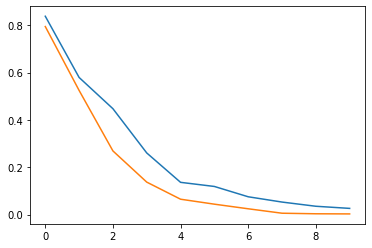

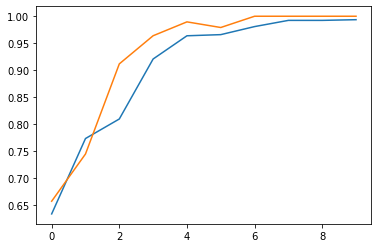

In [56]:
from torch.utils.data import random_split
train_loc = "./train/"
test_loc = "./test/"
for k in range(10,110,10):
    trainset = datasets.DatasetFolder(train_loc, transform = data_transform(TRAIN), loader=load_file, extensions="npy")
    testset = datasets.DatasetFolder(test_loc, transform = data_transform(TEST), loader=load_file, extensions="npy")
    
    len_us=len(trainset)
    len_train=int(k*len_us/100)
    len_val=len_us-len_train
    train_ds,val_ds=random_split(trainset,[len_train,len_val])

    print("original train dataset length:", len_us)
    print("new train dataset length:", len(train_ds))
    
    trainloader = DataLoader(train_ds,batch_size = 16,shuffle = True)
    testloader = DataLoader(testset,batch_size = 32,shuffle = False)
    
    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Linear(512, 8),
        nn.LogSoftmax(dim=1) # For using NLLLoss()
    )

 
    model.load_state_dict(torch.load("./ssl_init_weights_rotation.pt", map_location='cpu')['model_state_dict'])
    model.fc = nn.Sequential(
        nn.Linear(512, 3),
        nn.LogSoftmax(dim=1) # For using NLLLoss()
    )
    model.to(device);
    for param in model.parameters():
        param.require_grad = True   


    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(),lr = 0.0001)
    schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)
#     device = 'cpu'
    training(trainloader, testloader, 10, f"SSL_init_{k}")

### Comparision of results

In [58]:
acc_pretrained_false = []
acc_pretrained_imageNet = []
acc_pretrained_SSL = []
test_loc = "./test/"
testset = datasets.DatasetFolder(test_loc, transform = data_transform(TEST), loader=load_file, extensions="npy")
testloader = DataLoader(testset,batch_size = 32,shuffle = False)

for k in range(10,110,10):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Linear(512, 3),
        nn.LogSoftmax(dim=1) # For using NLLLoss()
    )

    for param in model.parameters():
        param.require_grad = True
    model.to(device);
    
    model.load_state_dict(torch.load(f"./rand_init_{k}.pt")['model_state_dict'])
    model.eval()
    with torch.no_grad():
        test_acc = 0.0
        for images,labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)

            ps = model(images)
            test_acc += accuracy(ps,labels)


        avg_test_acc = test_acc / len(testloader)
        acc_pretrained_false.append(avg_test_acc)
        
    


for k in range(10,110,10):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Linear(512, 3),
        nn.LogSoftmax(dim=1) # For using NLLLoss()
    )

    for param in model.parameters():
        param.require_grad = True
    model.to(device);
    
    model.load_state_dict(torch.load(f"./ImageNet_init_{k}.pt")['model_state_dict'])
    model.eval()
    with torch.no_grad():
        test_acc = 0.0
        for images,labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)

            ps = model(images)
            test_acc += accuracy(ps,labels)


        avg_test_acc = test_acc / len(testloader)
        acc_pretrained_imageNet.append(avg_test_acc)
        

        
for k in range(10,110,10):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Linear(512, 3),
        nn.LogSoftmax(dim=1) # For using NLLLoss()
    )

    for param in model.parameters():
        param.require_grad = True
    model.to(device);
    
    model.load_state_dict(torch.load(f"./SSL_init_{k}.pt")['model_state_dict'])
    model.eval()
    with torch.no_grad():
        test_acc = 0.0
        for images,labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)

            ps = model(images)
            test_acc += accuracy(ps,labels)


        avg_test_acc = test_acc / len(testloader)
        acc_pretrained_SSL.append(avg_test_acc)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [69]:
x = list(range(10,110,10))

In [70]:
x

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

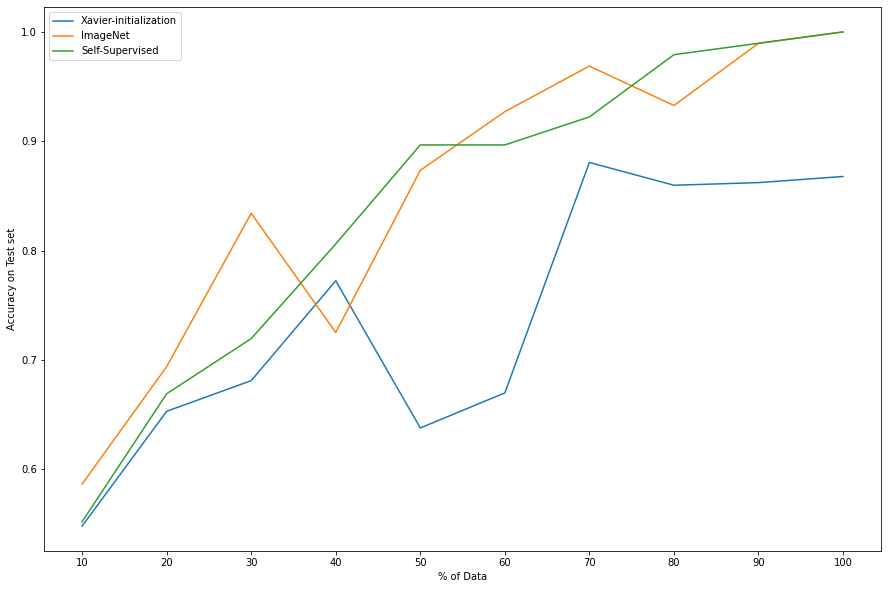

In [72]:
plt.figure(figsize=(15,10))
plt.plot(x, acc_pretrained_false, label = 'Xavier-initialization')
plt.plot(x, acc_pretrained_imageNet, label = 'ImageNet')
plt.plot(x, acc_pretrained_SSL, label = 'Self-Supervised')

plt.legend()
plt.xlabel("% of Data")
plt.ylabel("Accuracy on Test set")
plt.xticks(x)
plt.savefig("result.png")


In [65]:
print(acc_pretrained_false)
print(acc_pretrained_imageNet)
print(acc_pretrained_SSL)

[tensor(0.5481), tensor(0.6530), tensor(0.6811), tensor(0.7724), tensor(0.6378), tensor(0.6699), tensor(0.8806), tensor(0.8598), tensor(0.8622), tensor(0.8678)]
[tensor(0.5865), tensor(0.6939), tensor(0.8341), tensor(0.7252), tensor(0.8734), tensor(0.9271), tensor(0.9688), tensor(0.9327), tensor(0.9896), tensor(1.)]
[tensor(0.5521), tensor(0.6691), tensor(0.7196), tensor(0.8061), tensor(0.8966), tensor(0.8966), tensor(0.9223), tensor(0.9792), tensor(0.9896), tensor(1.)]
